# Evolution de la politique d'augmentation de données

Cette fois nous ferons plus attention à ne pas introduire des images du dataset de test dans le dataset d'entraînement, même si elles sont modifiées.

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import albumentations as alb

import tensorflow as tf
from tensorflow.keras import layers

import tools

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
2024-06-22 14:35:38.631830: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 14:35:38.632411: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 14:35:38.654766: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 14:35:38.768037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in oth

### Préparation des datasets

In [2]:
original_datasetX = []
original_datasetY = []
augmented_pneumonia_datasetX = []
augmented_pneumonia_datasetY = []

test_datasetX = []
test_datasetY = []

image_size = (200, 200)
def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    original_datasetX.append(new_img)
    # replace normal with 0 and pneumonia with 1 in order to have numerical labels
    category = 0 if category == "NORMAL" else 1
    original_datasetY.append(category)

tools.browse_imgs(load_datasets)

# après avoir chargé le dataset, on met directement de coté les images de test afin d'être sûr de ne pas les modifier
original_datasetX, test_datasetX, original_datasetY, test_datasetY = train_test_split(original_datasetX, original_datasetY, test_size=0.2, random_state=1)

for i in range(0, len(original_datasetX)):
    image = original_datasetX[i]
    category = original_datasetY[i]
    transformed_img = alb.hflip(image)
    
    if category == 1:
        augmented_pneumonia_datasetX.append(transformed_img)
        augmented_pneumonia_datasetY.append(category)

# normalizing the images
original_datasetX = np.array(original_datasetX) / 255
original_datasetY = np.array(original_datasetY)
test_datasetX = np.array(test_datasetX) / 255
test_datasetY = np.array(test_datasetY)
augmented_pneumonia_datasetX = np.array(augmented_pneumonia_datasetX) / 255
augmented_pneumonia_datasetY = np.array(augmented_pneumonia_datasetY)

# la seed nous permettra de mélanger les datasets X et Y de la même manière
random_seed = 5

#### CNN - Convolution Neural Network

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [3]:
# This line sets the number of output classes for your model
num_classes = 1
# This line sets the size of the kernel to be used in the convolutional layers. The kernel is
# a small matrix that is used for blurring, sharpening, embossing, edge detection, and more
core_size = 8

# he Sequential model is a linear stack of layers that you can add to in order
model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(16, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 193, 193, 16)   │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 89, 89, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,073,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,319,477 (8.85 MB)

 Trainable params: 2,319,477 (8.85 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
metrics = ['recall', 'precision']
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=metrics)

In [5]:
history = None
def train_and_test_with_confusion_matrix(datasetX, datasetY, epoch=2):
    global history
    xtrain, xval, ytrain, yval = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
    history = model.fit(xtrain,
          ytrain,
          validation_data=(xval, yval),
          epochs=epoch)
    
    y_pred = model.predict(test_datasetX)
    tools.display_confusion_matrix_and_scores(test_datasetY, y_pred)

### testing model on augmented pneumonia dataset (only pneumonia images are augmented in order to focus on pneumonia detection)

In [6]:
x = np.concatenate((original_datasetX, augmented_pneumonia_datasetX))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((original_datasetY, augmented_pneumonia_datasetY))
np.random.seed(random_seed)
np.random.shuffle(y)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


203/203 ━━━━━━━━━━━━━━━━━━━━ 46s 218ms/step - loss: 0.3851 - recall: 0.9527 - val_loss: 0.1132 - val_recall: 0.9856
Epoch 2/2
203/203 ━━━━━━━━━━━━━━━━━━━━ 44s 215ms/step - loss: 0.1420 - recall: 0.9720 - val_loss: 0.1012 - val_recall: 0.9827
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


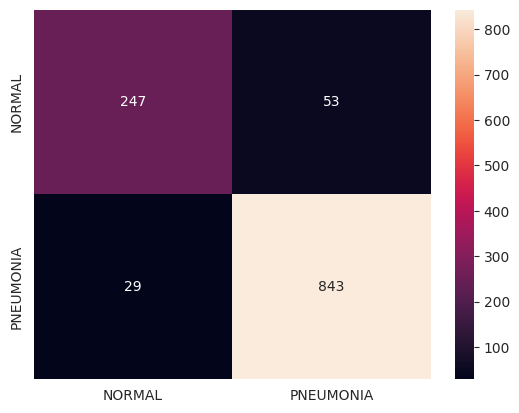

recall : 0.966743119266055 | precision : 0.9408482142857143 | f1score : 0.9536199095022625


In [7]:
train_and_test_with_confusion_matrix(x, y, epoch=2)

KeyError: 'precision'

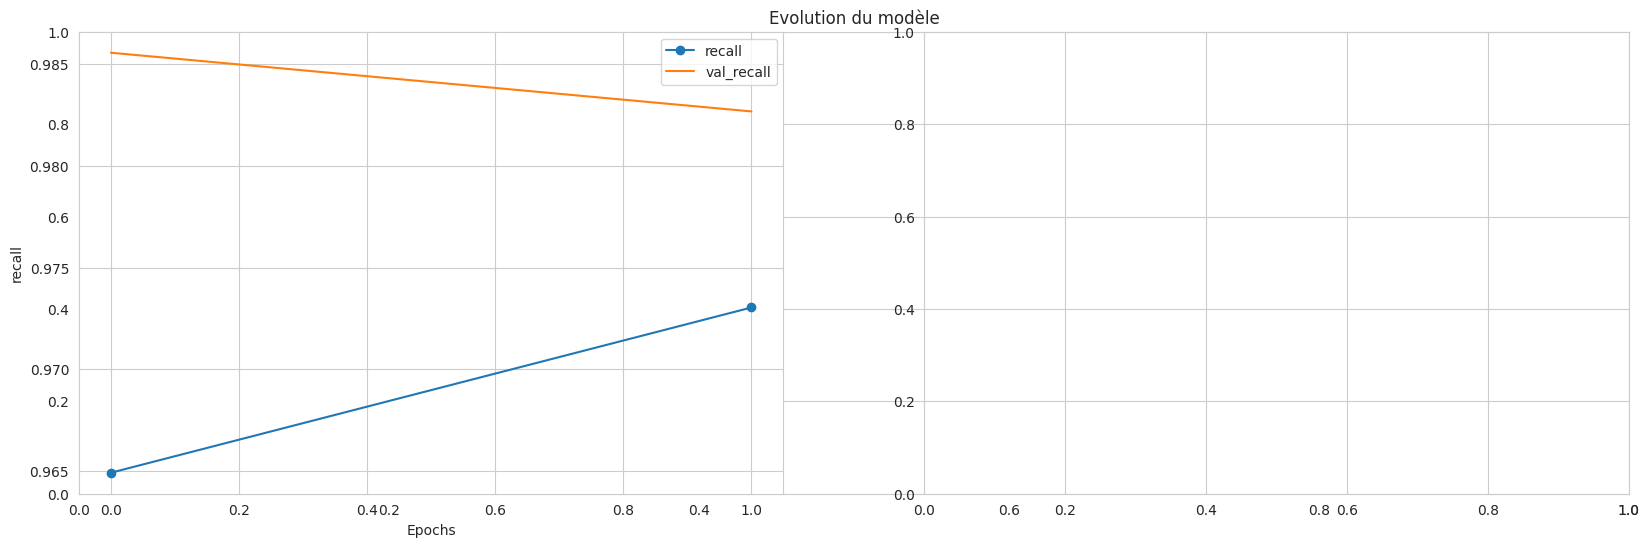

In [8]:
tools.plot_history(history, metrics)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


203/203 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - loss: 0.1386 - precision: 0.9680 - recall: 0.9753 - val_loss: 0.1061 - val_precision: 0.9810 - val_recall: 0.9683
Epoch 2/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 214ms/step - loss: 0.1078 - precision: 0.9710 - recall: 0.9769 - val_loss: 0.1293 - val_precision: 0.9550 - val_recall: 0.9949
Epoch 3/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - loss: 0.0939 - precision: 0.9760 - recall: 0.9794 - val_loss: 0.0897 - val_precision: 0.9704 - val_recall: 0.9921
Epoch 4/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - loss: 0.0825 - precision: 0.9800 - recall: 0.9858 - val_loss: 0.1184 - val_precision: 0.9881 - val_recall: 0.9553
Epoch 5/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step - loss: 0.0764 - precision: 0.9833 - recall: 0.9826 - val_loss: 0.1321 - val_precision: 0.9902 - val_recall: 0.9444
Epoch 6/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step - loss: 0.1109 - precision: 0.9786 - recall: 0.9725 - val_loss: 0.0836 - val_precision: 0.9790 - val_

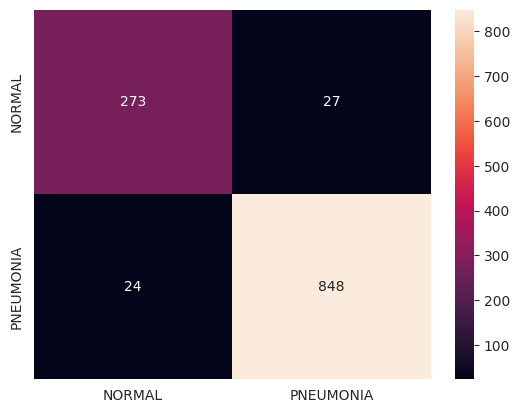

recall : 0.9724770642201835 | precision : 0.9691428571428572 | f1score : 0.9708070978820835


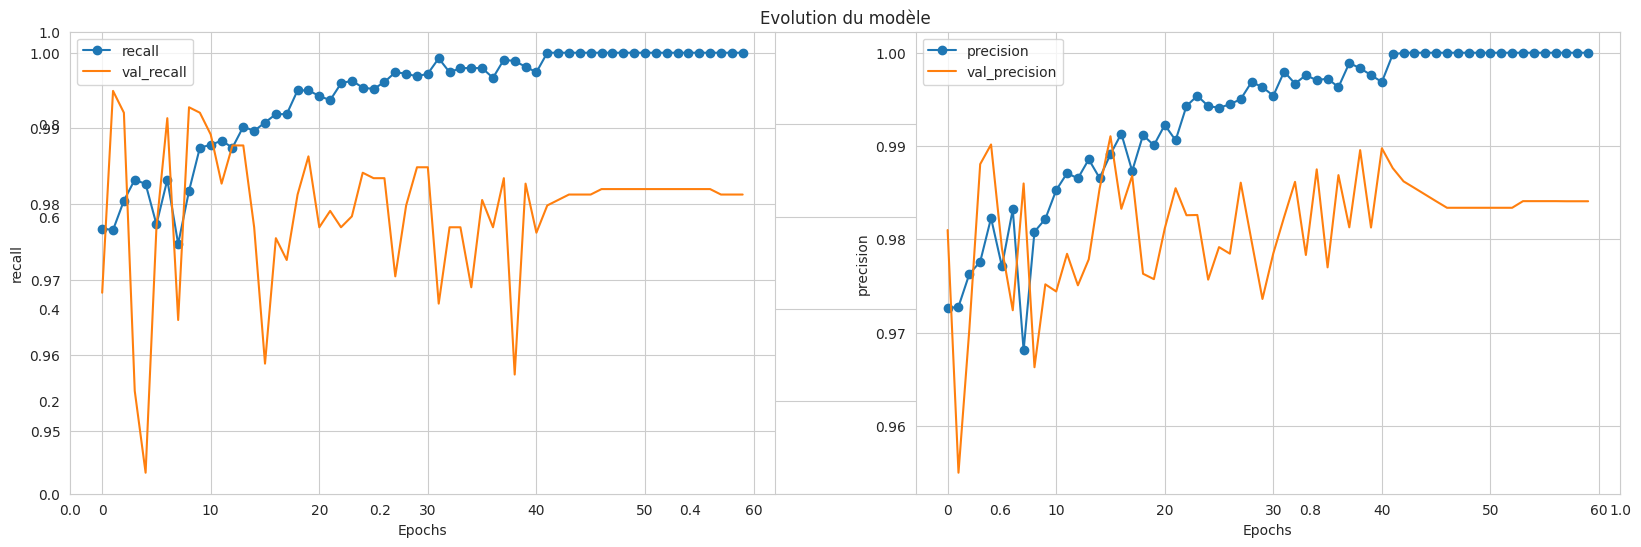

In [11]:
train_and_test_with_confusion_matrix(x, y, epoch=60)
tools.plot_history(history, metrics)